In [178]:
from src.systems.utils import *
from src.models.approximator import *
from src.models.utils import *
from src.systems import TrainableDynamicalSystem, GridSearchDynamicalSystem
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Visualize the nonlinear dataset given

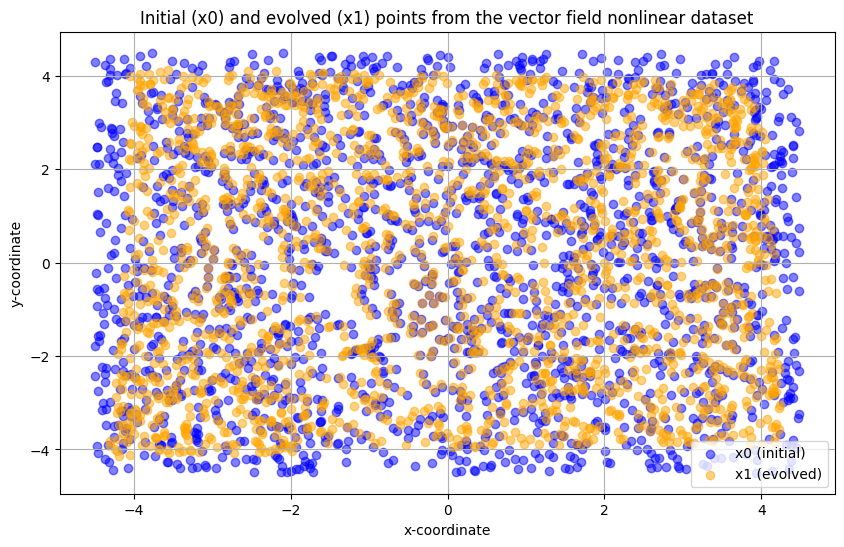

In [179]:
data_file_path = Path("data/vector_field_nonlinear.txt")
x0, x1 = load_vectorfield(data_file_path)

plt.figure(figsize=(10, 6))
plt.scatter(x0[:, 0], x0[:, 1], color='blue', alpha=0.5, label='x0 (initial)')
plt.scatter(x1[:, 0], x1[:, 1], color='orange', alpha=0.5, label='x1 (evolved)')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Initial (x0) and evolved (x1) points from the vector field nonlinear dataset')
plt.legend()
plt.grid(True)
plt.show()

Part 1: Estimate the vector field with a linear operator and compute the mean squared error to the solution after ∆t as close as possible to x1

In [180]:
# estimate the vector field with a linear operator 
delta_t = 0.01
linear_model = TrainableDynamicalSystem(approximator=LinearApproximator).fit(x0=x0, x1=x1, delta_t=delta_t)
A = linear_model.weights
print(f"A is \n{np.round(A, 3)}")

# predict end points
x0 = np.array(x0)
x1_approx = x0 + delta_t * (x0 @ A.T)

# compute MSE
mse = compute_mse(x1, x1_approx)
print(f"Mean Squared Error: {mse:.6f}")

A is 
[[-1.002  0.087]
 [-0.025 -4.327]]
Mean Squared Error: 0.037287


Part 2: Approximate the vector field using radial basis functions and compare the results with the linear approximation

First, find the most optimal number of centers L and the most optimal scaling parameter eps

In [181]:
data_file_path = Path("data/vector_field_nonlinear.txt")
x0, x1 = load_vectorfield(data_file_path)

center_values = np.arange(100, 1000, 10)
eps_values = np.logspace(-2, 1, 10) 
results= []

# loop over L and eps and compute MSE
for L in center_values:
    for eps in eps_values:
        rbf_model = RBFApproximator()
        rbf_model.L = L
        rbf_model.eps = eps
        rbf_model.fit(x0, x1)
        x1_pred = rbf_model.predict(x0)
        
        mse = compute_mse(x1, x1_pred)
        results.append((L, eps, mse))
        
# find the optimal parameters based on MSE
results = np.array(results, dtype=[('L', int), ('eps', float), ('mse', float)])
optimal_idx = np.argmin(results['mse'])
optimal_L = results[optimal_idx]['L']
optimal_eps = results[optimal_idx]['eps']
optimal_mse = results[optimal_idx]['mse']

print(f"Optimal number of centers: {optimal_L}")
print(f"Optimal scaling parameter (epsilon): {optimal_eps}")
print(f"Minimum MSE: {optimal_mse}")

Optimal number of centers: 940
Optimal scaling parameter (epsilon): 2.154434690031882
Minimum MSE: 2.965591963260582e-15


Visualize the results of grid search

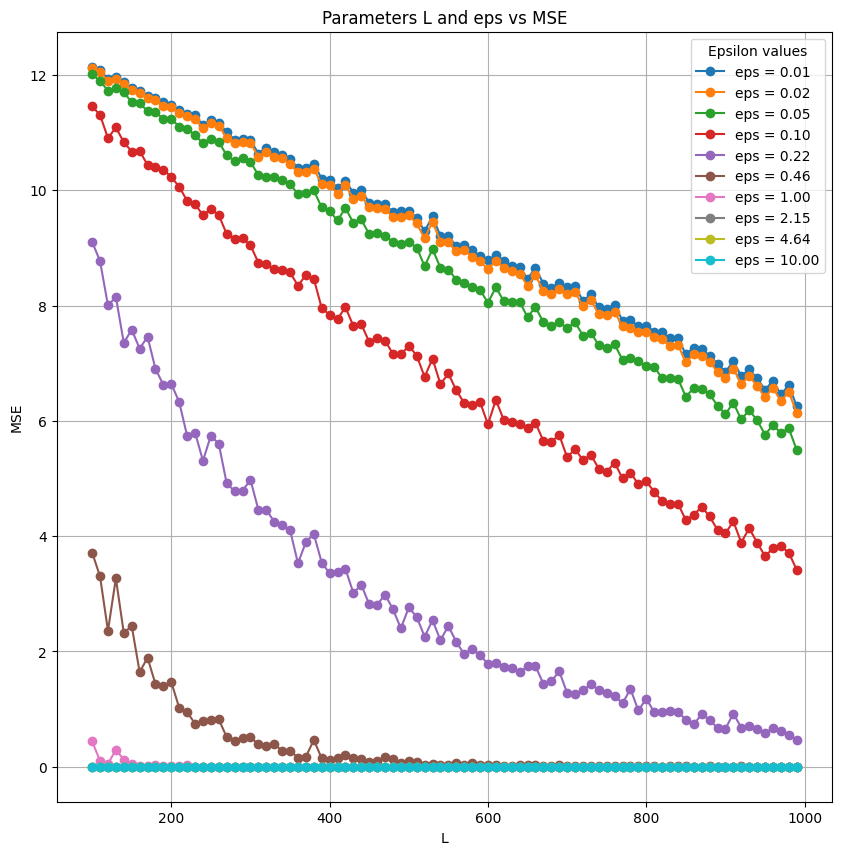

In [182]:
# visualizing results with the suport of chatgpt 
plt.figure(figsize=(10, 10))
for eps in eps_values:
    subset = results[results['eps'] == eps]
    plt.plot(subset['L'], subset['mse'], marker='o', label=f"eps = {eps:.2f}")
    
plt.xlabel("L")
plt.ylabel("MSE")
plt.title("Parameters L and eps vs MSE")
plt.legend(title="Epsilon values")
plt.grid()
plt.show()

In [183]:
dx_dt = (x1 - x0) / delta_t 

# define RBF approximator using found optimal parameters from above 
RBF = RBFApproximator()
RBF.L = optimal_L
RBF.eps = optimal_eps

# for generalization and more accurate evaluation we divide the dataset into train and test
x0_train, x0_test, dx_dt_train, dx_dt_test = train_test_split(x0, dx_dt, test_size=0.2, random_state=42)
RBF = RBF.fit(x0_train, dx_dt_train)
RBF_prediction = RBF.predict(x0_test)

# compute MSE
mse_rbf = compute_mse(dx_dt_test, RBF_prediction)
print(f"Mean Squared Error (RBF Approximation): {mse_rbf}")

Mean Squared Error (RBF Approximation): 4.319717849626521e-11


Part 3: Find steady states of the system using RBF approximator and optimal parameters

In [212]:
data_file_path = Path("data/vector_field_nonlinear.txt")
x0, x1 = load_vectorfield(data_file_path)

RBF = RBFApproximator()
RBF.L = optimal_L
RBF.eps = optimal_eps
RBF.fit(x0, (x1 - x0) / 0.01)

# simulate the system over a larger time horizon
def simulate(x0, rbf_model, time_steps=1000, dt=0.01):
    trajectory = [x0]
    current_points = x0
    for _ in range(time_steps):
        vector_field = rbf_model.predict(current_points)
        next_points = current_points + vector_field * dt
        trajectory.append(next_points)
        current_points = next_points
    return np.array(trajectory)

trajectories = simulate(x0, RBF)

# find (unique) steady states and print the results
final_points = trajectories[-1]  # Points after the simulation
vector_field_at_final = RBF.predict(final_points)
steady_states = final_points[np.linalg.norm(vector_field_at_final, axis=1) < 1e-3]
unique_steady_states = np.unique(np.round(steady_states, decimals=3), axis=0)

print("Steady states of the system:")
print(unique_steady_states)
print("Number of steady states of the system:")
print(len(unique_steady_states))

Steady states of the system:
[[-3.779 -3.283]
 [-2.805  3.131]
 [ 3.     2.   ]
 [ 3.584 -1.848]]
Number of steady states of the system:
4
